In [ ]:
# load the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from datetime import datetime
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

import requests
import string

import urllib.request

from datetime import datetime

In [ ]:
!pip install yfinance

In [ ]:
# Install Yahoo Finance package if it's not already installed 
try:
    import yfinance as yf
except ImportError:
    
    import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

# this code is to be able to see the plot in the Jupyter notebook
%matplotlib inline

In [ ]:
#Question 1
# We chose  microsoft stock
msft = yf.download('MSFT',  start='2002-01-01',  end='2022-12-31',  progress=False)
msft.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-02,33.325001,33.555000,32.755001,33.520000,20.913071,48124000
2002-01-03,33.555000,34.625000,33.544998,34.615002,21.596239,67590800
2002-01-04,34.625000,34.955002,34.334999,34.450001,21.493298,52731400
2002-01-07,34.875000,35.009998,34.174999,34.279999,21.387226,58508800
2002-01-08,34.345001,34.930000,34.000000,34.689999,21.643030,47736400


In [ ]:
msft.index.names = ["date"] # I will rename the index "Date" for "date" so that I can merge it later with the fama-french file. # if you want to rename a columnn, do msft.rename(columns={"old_name":"new_name"})

In [ ]:
# this gives us daily returns
msft['ret'] = msft[['Adj Close']].pct_change()

In [ ]:
#monthly returns #resample the data at the monthly frequency and take the last observation each month
msft_monthly = msft.resample("M").last()[['Adj Close']]
msft_monthly

In [ ]:
# now we have monthly returns.
msft_monthly['ret'] = msft_monthly[['Adj Close']].pct_change()


<AxesSubplot:xlabel='date'>

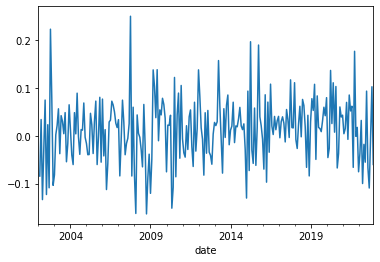

In [ ]:
#Question 2

msft_monthly['ret'].plot()

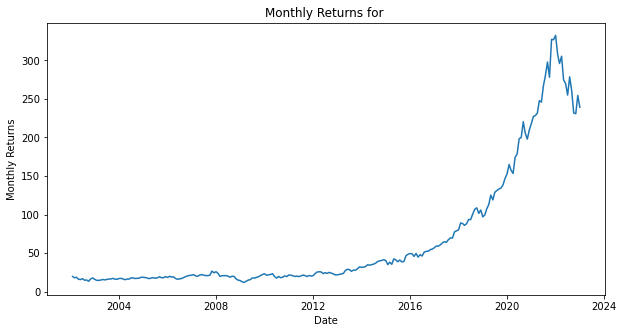

In [ ]:
# Plot the monthly returns using matplotlib
plt.figure(figsize=(10, 5))
plt.plot(msft_monthly)
plt.xlabel('Date')
plt.ylabel('Monthly Returns')
plt.title('Monthly Returns for ')
plt.show()

In [ ]:
#Question 3

# first, create a lag one month return
msft_monthly["ret_lag1"] = msft_monthly["ret"].shift()
reg = smf.ols("ret~ret_lag1", data=msft_monthly).fit()  # this is how you run a regression

# to view the regression output such as the coefficient loadings, t-stats, p-values, $R^2$
reg.summary()   # MSE is low, it suggests that using a one-month lag return can be a useful predictor of the next month's return

In [ ]:
#Question 4

# Download the Fama-French monthly market returns dataset
import io
from google.colab import files
uploaded=files.upload()


Saving F-F_Research_Data_Factors.CSV to F-F_Research_Data_Factors.CSV
Saving F-F_Research_Data_Factors_daily.CSV to F-F_Research_Data_Factors_daily.CSV


In [ ]:
#upload ff
ff_data = pd.read_csv(io.BytesIO(uploaded['F-F_Research_Data_Factors.CSV']), skiprows=3, nrows=1124, index_col=0)
ff_data_daily = pd.read_csv(io.BytesIO(uploaded['F-F_Research_Data_Factors_daily.CSV']), skiprows=3, nrows=1124, index_col=0)
#ff_data.head()
ff_data.head()

In [ ]:
# Rename the columns
ff_data.columns = ['Market', 'SMB', 'HML', 'RF']
ff_data

In [ ]:
# Convert the market returns to decimal format
ff_data['Market'] = ff_data['Market'] / 100

In [ ]:
# Calculate monthly market returns from the Fama-French dataset
market_returns = ff_data.loc[201802:202001, 'Market']


In [ ]:
# Compute the buy-and-hold monthly returns for the stock and the market
msft_monthly_bh_returns = (1 + msft_monthly).cumprod()
market_bh_returns = (1 + market_returns).cumprod()

In [ ]:
# Compute the monthly abnormal returns
abnormal_returns = msft_monthly_bh_returns - market_bh_returns


In [ ]:
#Question 5

# Plot the monthly abnormal returns
abnormal_returns.plot(figsize=(12, 6), title='Monthly Abnormal Returns for AAPL vs Market')
plt.ylabel('Abnormal Returns')
plt.show()

In [ ]:
#Question 6

'''we can see that the stock's abnormal returns are mostly positive and higher than the market's abnormal returns during the period from 2018 to 2022. This indicates that the stock has outperformed the market during that time interval.'''

In [ ]:
#Question 7

# Calculate excess returns by subtracting the risk-free rate from stock returns
risk_free_rate = ff_data.loc[201001:202001, 'RF']
excess_returns = msft_monthly - risk_free_rate

# Calculate average excess return and standard deviation of excess returns
avg_excess_return = excess_returns.mean()
std_excess_return = excess_returns.std()


# Calculate Sharpe ratio as average excess return divided by standard deviation of excess returns
sharpe_ratio = avg_excess_return / std_excess_return

print(sharpe_ratio)

In [ ]:
#Question 8
tickers = ["MSFT", "AAPL", "AMZN", "IBM", "GOOGL"]

df = []  # we will store our data for each ticker in this "df" dataframe

for t in tickers:
    df_tmp = yf.download(t,  start='2010-01-01',  end='2022-12-31',  progress=False)
    df_tmp = df_tmp[["Adj Close"]].rename(columns={"Adj Close":t})  # rename the columns "Adj Close" with the ticker name
    df.append(df_tmp)  # store the retrieved data in df
    
df = pd.concat(df, axis=1)  # concatenate all the retrieved data in one dataframe


# Calculate the monthly returns for each stock
monthly_returns = df.resample('M').ffill().pct_change()

# Print the first 5 rows of the monthly returns dataframe
print(monthly_returns.head())

In [ ]:
#Question 9

ff_data_r = pd.read_csv(io.BytesIO(uploaded['F-F_Research_Data_Factors.CSV']))
ff_data_r
#msft_monthly
ff_data_r.rename(columns={"yyyymm":"date"})
ff_data_r.head()

# running the capm regression

msft_monthly = msft_monthly.merge(ff_data_r, on="date")


# compute the excess returns
msft_monthly["exret"] = msft_monthly["ret"]-msft_monthly["RF"]

# rename the column "Mkt-RF" for "exmkt" for excess market return
msft_monthly = msft_monthly.rename(columns={"Mkt-RF":"exmkt"})

# running the CAPM regression
reg_capm = smf.ols("exret~exmkt", data=msft_monthly).fit()

reg_capm.summary()


In [ ]:
# Define the list of symbols and the risk-free rate
symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
risk_free_rate = 0.03 / 12  # 3% annual risk-free rate, divided by 12 for monthly rate

# Define the start and end dates for the CAPM regression
start_date = '2010-01-01'
end_date = '2021-12-31'

# Retrieve the historical prices for each stock
prices = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Calculate the monthly returns for each stock
monthly_returns = prices.resample('M').ffill().pct_change()


ff_data_r['Mkt-RF'] = ff_data_r['Mkt-RF'] / 100  # Convert percentage to decimal
ff_data_r['Excess_Mkt'] = ff_data_r['Mkt-RF'] - risk_free_rate

# Merge the monthly returns of the stocks with the excess market returns
data = pd.merge(monthly_returns, ff_data_r[['Date', 'Excess_Mkt']], left_index=True, right_on='Date')

# Calculate the excess returns for each stock
excess_returns = data[symbols].sub(risk_free_rate)

# Run the CAPM regression for each stock
results = []
for symbol in symbols:
    y = excess_returns[symbol]
    X = sm.add_constant(data['Excess_Mkt'])
    model = sm.OLS(y, X, missing='drop')
    results.append(model.fit())

# Print the beta coefficient for each stock
for i, symbol in enumerate(symbols):
    print(f'{symbol}: beta = {results[i].params["Excess_Mkt"]:.2f}')

In [ ]:
#Question 10

# Run the Fama-MacBeth regression for each stock # if the beta coefficient to be statistically significant then CAPM holds
    y = excess_returns[symbol]
    X = sm.add_constant(data['Excess_Mkt'])
    model = sm.FamaMacBeth(y, X, missing='drop')
    results = model.fit()
    print(f'{symbol}: beta = {results.params["Excess_Mkt"]:.2f}, p-value = {results.pvalues["Excess_Mkt"]:.4f}')


In [ ]:

#Question 11
#equally-weighted and value-weighted return portfolios.

tickers = ["MSFT", "AAPL", "AMZN", "IBM", "GOOGL"]

df = []  # we will store our data for each ticker in this "df" dataframe

for t in tickers:
    df_tmp = yf.download(t,  start='2010-01-01',  end='2022-12-31',  progress=False)
    df_tmp = df_tmp[["Adj Close"]].rename(columns={"Adj Close":t})  # rename the columns "Adj Close" with the ticker name
    df.append(df_tmp)  # store the retrieved data in df
    
df = pd.concat(df, axis=1)  # concatenate all the retrieved data in one dataframe
df.head()

In [ ]:

# we will use this later, let's store the prices
prc = df.copy()

In [ ]:
# get the monthly returns
df = df.resample("M").last()
df = df.pct_change()
#df.head()

# turn the dataframe (df) with stock returns into gross returns
df_gross = df+1

# put in the first of the dataset, 0.25 everywhere
df_gross.iloc[0] = [0.25, 0.25, 0.25, 0.25]

# compute the equal-weighted returns
df_compound = df_gross.cumprod()  # compute the cumulative returns of your invesment in each stock

# now you can compute the monthly returns of your portfolio
df_ew = df_compound.copy()
df_ew['ret'] = df_ew["val"].pct_change()

In [ ]:
#Question 12

# that's your total monthly returns each month!
df_ew['ret'].plot()

#### compute buy-and-hold returns for your equal-weighted portfolio
(1+df_ew['ret']).cumprod().plot()  # cumprod is the cumulative product


In [ ]:
#Question 13
#Event studies

aapl = yf.download(t,  start='2010-01-01',  end='2022-12-31',  progress=False)
aapl["ret"] = aapl["Adj Close"].pct_change()

aapl.head()


In [ ]:
aapl = aapl.reset_index()
aapl = aapl.rename(columns={"Date":"date"})



In [ ]:
# because the the apple data is daily. let's load the daily fama-french data

ff_data_daily.head()
# because the data is in %, we must divide the columns by 100
ff_data_daily[["Mkt-RF", "SMB", "HML", "RF"]] = ff_data_daily[["Mkt-RF", "SMB", "HML", "RF"]]/100
ff_data_daily["Mkt"] = ff_data_daily["Mkt-RF"]-ff_data_daily["RF"]

In [ ]:
# merge both datasets
aapl = aapl.merge(ff_data_daily, on=['date'], how='left')

aapl.head()
# select date window before and after an earnings announcement of our choice. Let's take the earnings of Apr 28, 2021, the earnings surprise was negative, +44.84%
aapl_short = aapl[(aapl['date'] >= "2021-04-01") & (aapl['date'] <= "2021-04-30")]

aapl_short.head()


In [ ]:
# now, when you do an event study, you have to substract the returns for the stock minus the returns of the market. here's the way to do it:

aapl_short['cumret'] = (1+aapl_short['ret']).cumprod()  # cumulative product of gross returns
aapl_short['cummkt'] = (1+aapl_short['Mkt']).cumprod()  # cumulative product of gross returns

# compute the buy-and-hold-abnormal returns
aapl_short['bhar'] = aapl_short['cumret']-aapl_short['cummkt']

In [ ]:
# set dates as index
aapl_short = aapl_short.set_index("date")


In [ ]:
# plotting the BHAR around the earnings announcement date
fig = plt.figure()  # initiate the figure environment
aapl_short['bhar'].plot(color='b', linewidth=2)
plt.ylabel('Buy-and-hold abnormal return')
plt.xlabel('')
# Make sure you change the title of the figure accordingly. 
plt.title('Apple \n Expected EPS=0.99, Actual EPS=1.40, Surprise=+41.84%')
# This last line of code draws the vertical line in the plot
plt.axvline(x='2021-04-28', color='k', linestyle='-.', alpha=.75)

# for AAPL, on the date of the announcement, despite large surprises, the return jump was not super high... but days before the returns increased subtantially. Could it be that markets anticipated a large positive news?

In [ ]:
#Question 13

#Sentiment Analysis

# Load the Loughran and McDonald dictionnary
lm = pd.read_excel(io.BytesIO(uploaded['LoughranMcDonald_MasterDictionary_2014.xlsx']))


# get the lists of positive/negative words
lmpos = list(lm[lm.Positive!=0]['Word'])
lmneg = list(lm[lm.Negative!=0]['Word'])

In [ ]:
# this section of the notebook will contains helper classes/functions
# for web crawling

from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def get_article_body(article_url, body_html_element):
    """ This is a helper function that provides us with the body of an article
    article_url is the link to the article
    body_html_element is where the article body is stored
        news websites usually wrap their story's body in <p> tags which stand for paragraph
        to find out which tag the website you chose uses, you need to inspect the page (ctrl+shift+i)
    """
        
    # get the story
    page = requests.get(article_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    # get all the text within the html element <p>
    # each paragraph will be an element of the returned list
    # note that what we got here is in HTML
    html_text = soup.find_all(body_html_element)
    
    # convert HTML to regular string
    stripped_text = []
    for t in html_text:
        t = strip_tags(str(t))
        stripped_text.append(t)
    
    return " ".join(stripped_text)


In [ ]:
#Question 14

# Use Yahoo finance - I chose Uber for an example and calculate the returns
uber_returns = yf.download('UBER',  start='2019-01-01',  end='2022-02-04',  progress=False)
uber_returns = uber_returns[['Adj Close']].pct_change().rename(columns={'Adj Close': "Returns"})



In [ ]:
#Question 15

# My article of choice: 'Unfit' Uber loses London license over safety failures
url = "https://www.reuters.com/article/us-uber-britain-idUKKBN1XZ0VL"
neg_article_date = '2019-11-25'

# get the body text
article_body = get_article_body(article_url = url, body_html_element = 'p')

# convert all words to lower case
article_body = article_body.lower()

# remove non-letters (i.e., $ %)
natural_lang_data = ''.join([x for x in article_body if x in string.ascii_letters + '\'- '])

# remove stop words.
natural_lang_data = [x for x in natural_lang_data.split() if x not in stopwords.words('english')]
natural_lang_data.remove('-')

# process the data and get the sentiment
nwords = len(natural_lang_data) # number of words
npos = len([i for i in natural_lang_data if i.upper() in lmpos])  # number of positive words
nneg = len([i for i in natural_lang_data if i.upper() in lmneg])  # number of negative words
sentiment_score = (npos - nneg) / nwords


In [ ]:
# print sentiment score
print(sentiment_score)